In [261]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Task description

Bolt’s Delivery vertical is a three-sided marketplace that connects customers, restaurants and couriers.

Couriers travel to restaurants to pick up orders prepared by the restaurant. After the restaurant finishes preparation and the courier picks up the order, the courier travels to the customer to deliver the order. Our goal is to eliminate wasted time for the courier and have orders delivered to customers faster and on time, while the food is warm. Your task is to identify how we can reduce the time spent by a courier on an order using these datasets.

We expect your submission to cover the following angles:
- **Data discovery**: Identify where our biggest delivery inefficiencies take place
- **Business case**: Specify business benefits of reducing the largest identified inefficiency
- **Requirements definition**: Define at least one product feature to reduce the largest identified inefficiency
- **Feature validation**: Once the feature(s) are built, provide a specific example of a validation approach with design and steps

Please submit both the code you use to arrive at the results (preferably in notebook format - Python or R), and the document (written or presentation) that answers these questions. At Bolt, we stay efficient through concise and to-the point communication. Being succinct in your submission is highly encouraged.

We expect the exercise to take ±5 hours to complete and Data discovery to take most of your time. Keep in mind the submission does not need to be perfect: time-box your work and make the most out of it make assumptions where needed, and state them show us your thinking.

# Settings

In [21]:
sns.set_theme()

# Data mining

In [22]:
try:
    ord = pd.read_pickle('ord.pkl')
except FileNotFoundError:
    ord = pd.read_clipboard()
    ord.to_pickle(Path('ord.pkl'))

assert len(ord) == 65584, 'should be 65584 row'
# ord['order_promised_delivery_dt'] = pd.to_datetime(ord['order_promised_delivery'])

ord.head()

,task_id,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,restaurant_finished_preparation
0,1,1,15116,721,Bucharest,26.074823,44.415090,26.014888,44.428852,delivered,2021-10-15T03:31:11.000Z,2021-10-15T03:08:44.000Z
1,1,2,12572,1445,Bucharest,26.054794,44.454021,26.093656,44.434069,delivered,2021-10-15T03:46:07.000Z,2021-10-15T03:24:22.000Z
2,1,3,34814,891,Bucharest,26.049776,44.424410,26.020117,44.411906,delivered,2021-10-15T04:00:30.000Z,2021-10-15T03:45:39.000Z
3,1,4,17168,368,Bucharest,26.143047,44.430457,26.126890,44.417530,delivered,2021-10-15T04:15:53.000Z,2021-10-15T04:08:40.000Z
4,1,5,35129,721,Bucharest,26.074823,44.415090,26.030227,44.433221,delivered,2021-10-15T04:44:42.000Z,2021-10-15T04:28:17.000Z


In [23]:
try:
    stg = pd.read_pickle('stg.pkl')
except FileNotFoundError:
    stg = pd.read_clipboard()
    stg.to_pickle(Path('stg.pkl'))

assert len(stg) == 384937, 'should be 384 937 row'
# assert orders['Active Companies'].sum() == 69510, 'should be 69510 total'
# orders['Revenue'] = orders['Revenue'].str.replace(',','').astype(float)
# assert round(orders['Revenue'].sum(), 1) == round(10_572_217.58, 1), 'should be 10_572_217.58 total'
# assert orders['Orders'].sum() == 1_946_954, 'should be 1_946_954 total'
# orders['Order month_dt'] = pd.to_datetime(orders['Order month_dt'])
# orders['Revenue per Company'] = orders['Revenue'] / orders['Active Companies']
# orders['Orders per Company'] = orders['Orders'] / orders['Active Companies']
# orders['Avg order cost'] = orders['Revenue'] / orders['Orders']

stg.head()

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
0,1,Bucharest,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30.000,1
1,2,Bucharest,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10.000,1
2,3,Bucharest,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36.000,1
3,4,Bucharest,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,26.074581,44.414966,NaN,756.0,23.668382,4988.52796,2021-10-15 03:24:39.000,1
4,5,Bucharest,2,1970,motorbike,order_proposed_to_courier,2021-10-15 03:24:02.000,26.040890,44.479828,NaN,NaN,3076.131080,NaN,2021-10-15 03:46:36.000,1


# EDA

## Orders

In [24]:
primary_key = ['task_id', 'order_id', 'customer_id', 'restaurant_id', 'city']
assert ord.set_index(primary_key).index.is_unique, 'found duplicates'

In [25]:
ord.describe()

,task_id,order_id,customer_id,restaurant_id,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat
count,65584.0,65584.000000,65584.000000,65584.000000,65584.000000,65584.000000,65584.000000,65584.000000
mean,1.0,32792.500000,23769.572716,749.033621,26.095479,44.438890,26.095625,44.437762
std,0.0,18932.614364,13747.540045,442.920418,0.039094,0.023960,0.045539,0.029785
min,1.0,1.000000,1.000000,1.000000,25.974734,44.359138,25.967943,44.355151
25%,1.0,16396.750000,11899.000000,363.000000,26.075678,44.423497,26.061932,44.418767
50%,1.0,32792.500000,23736.000000,761.000000,26.097589,44.437441,26.100492,44.436236
75%,1.0,49188.250000,35707.250000,1138.000000,26.121313,44.450978,26.126956,44.455090
max,1.0,65584.000000,47643.000000,1511.000000,26.196190,44.571753,26.219887,44.558376


In [26]:
ord['task_id'].value_counts(dropna=False)

task_id
1    65584
Name: count, dtype: int64

In [28]:
ord['customer_id'].value_counts(dropna=False)

customer_id
36243    16
2617     13
42555    13
10174    12
47073    12
         ..
15567     1
20273     1
19305     1
20760     1
760       1
Name: count, Length: 43660, dtype: int64

In [29]:
ord['restaurant_id'].value_counts(dropna=False)

restaurant_id
1460    683
1227    658
149     648
853     616
1123    591
       ... 
283       1
567       1
783       1
749       1
1129      1
Name: count, Length: 1505, dtype: int64

In [30]:
ord['city'].value_counts(dropna=False)

city
Bucharest    65584
Name: count, dtype: int64

In [242]:
tmp = ord.groupby(['restaurant_id']).agg({'order_id': 'nunique'}).reset_index()
tmp.sort_values(by='order_id', ascending=False).head()

,restaurant_id,order_id
1453,1460,683
1220,1227,658
147,149,648
849,853,616
1117,1123,591


/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/2731864793.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('order_cnt')['restaurant_id'].nunique()


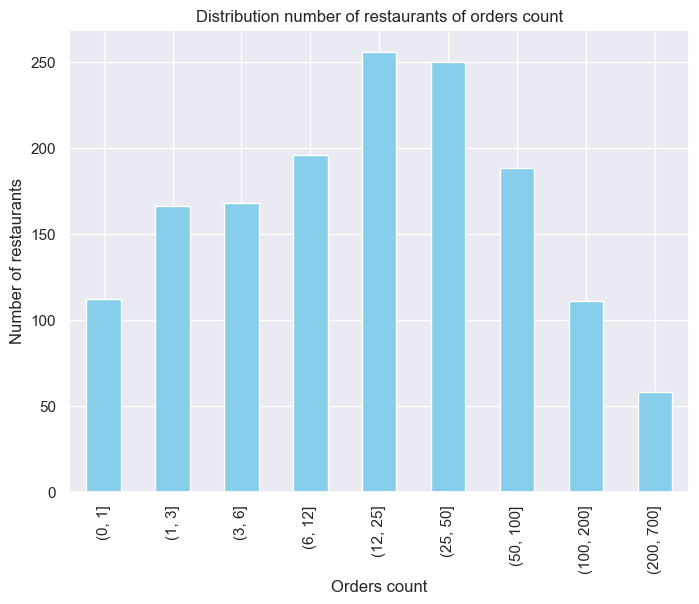

In [243]:
tmp = tmp[['restaurant_id', 'order_id']]

bins = [0, 1, 2, 3, 6, 12, 25, 50, 100, 200, 700]
tmp['order_cnt'] = pd.cut(tmp['order_id'], bins)
counts = tmp.groupby('order_cnt')['restaurant_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution number of restaurants of orders count')
plt.xlabel('Orders count')
plt.ylabel('Number of restaurants')

plt.show()

In [254]:
print(counts)

order_cnt
(0, 1]        112
(1, 2]         92
(2, 3]         74
(3, 6]        168
(6, 12]       196
(12, 25]      256
(25, 50]      250
(50, 100]     188
(100, 200]    111
(200, 700]     58
Name: restaurant_id, dtype: int64


/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/2923418407.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('order_cnt')['restaurant_id'].count()


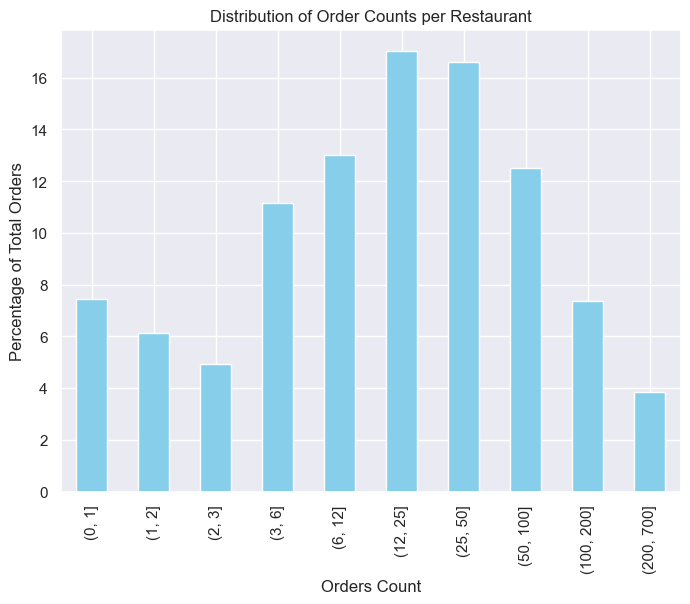

In [252]:
total_orders = tmp['order_id'].count()

bins = [0, 1, 2, 3, 6, 12, 25, 50, 100, 200, 700]
tmp['order_cnt'] = pd.cut(tmp['order_id'], bins)
counts = tmp.groupby('order_cnt')['restaurant_id'].count()
percentage = (counts / total_orders) * 100

plt.figure(figsize=(8, 6))
percentage.plot(kind='bar', color='skyblue')

plt.title('Distribution of Order Counts per Restaurant')
plt.xlabel('Orders Count')
plt.ylabel('Percentage of Total Orders')

plt.show()


In [251]:
print('Median number of restaurants for costumers is', round(tmp['order_id'].median()),'restaurants')

Median number of restaurants for costumers is 17 restaurants


In [266]:
tmp = ord.groupby(['customer_id']).agg({'order_id': 'nunique'}).reset_index()
tmp.sort_values(by='order_id', ascending=False).head()

,customer_id,order_id
33196,36243,16
39003,42555,13
2392,2617,13
36464,39802,12
9331,10174,12


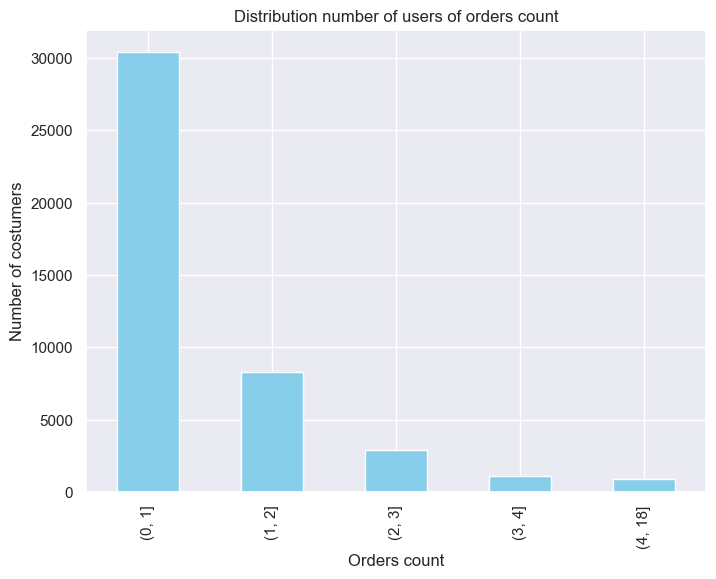

In [267]:
tmp = tmp[['customer_id', 'order_id']]

bins = [0, 1, 2, 3, 4, 18]
# bins = np.append(np.arange(0.5, 4, 1), np.inf)
tmp['order_cnt'] = pd.cut(tmp['order_id'], bins)
counts = tmp.groupby('order_cnt')['customer_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution number of users of orders count')
plt.xlabel('Orders count')
plt.ylabel('Number of costumers')

plt.show()

In [259]:
print(counts)

order_cnt
(0, 1]     30415
(1, 2]      8327
(2, 3]      2883
(3, 4]      1140
(4, 18]      895
Name: customer_id, dtype: int64


In [270]:
tmp = ord.groupby(['restaurant_id']).agg({'customer_id': 'nunique'}).reset_index()
tmp.sort_values(by='customer_id', ascending=False).head()

,restaurant_id,customer_id
1453,1460,606
147,149,603
849,853,562
1117,1123,536
1220,1227,532


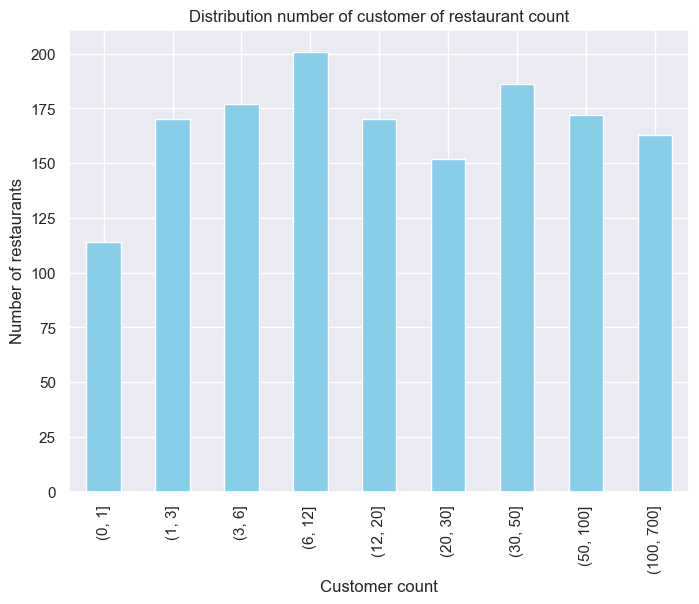

In [271]:
tmp = tmp[['restaurant_id', 'customer_id']]

bins = [0, 1, 3, 6, 12, 20, 30, 50, 100, 700]
tmp['customer_cnt'] = pd.cut(tmp['customer_id'], bins)
counts = tmp.groupby('customer_cnt')['restaurant_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution number of customer of restaurant count')
plt.xlabel('Customer count')
plt.ylabel('Number of restaurants')

plt.show()

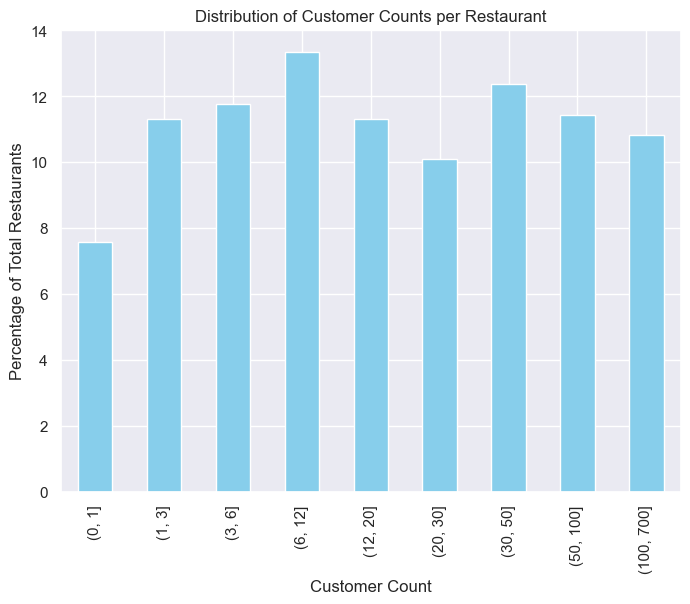

In [272]:
total_restaurants = tmp['restaurant_id'].nunique()

bins = [0, 1, 3, 6, 12, 20, 30, 50, 100, 700]
tmp['customer_cnt'] = pd.cut(tmp['customer_id'], bins)
counts = tmp.groupby('customer_cnt')['restaurant_id'].nunique()
percentage = (counts / total_restaurants) * 100

plt.figure(figsize=(8, 6))
percentage.plot(kind='bar', color='skyblue')

plt.title('Distribution of Customer Counts per Restaurant')
plt.xlabel('Customer Count')
plt.ylabel('Percentage of Total Restaurants')

plt.show()

## Stages

In [233]:
tmp = ord.groupby(['order_state']).agg({'order_id': 'nunique'}).reset_index()
tmp.sort_values(by='order_id', ascending=False).head()

,order_state,order_id
0,delivered,65473
1,failed,111


In [62]:
primary_key = ['log_id', 'city', 'order_id', 'courier_id', 'vehicle_type', 'order_stage','task_id']
assert stg.set_index(primary_key).index.is_unique, 'found duplicates'

In [63]:
stg.describe()

,log_id,order_id,courier_id,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,task_id
count,384937.000000,384937.000000,384937.000000,384860.000000,384860.000000,62055.000000,64073.000000,256666.000000,192311.000000,384937.0
mean,192469.000000,32811.255198,1533.399533,26.095522,44.438416,181.191330,559.958750,239.329572,848.316795,1.0
std,111121.884623,18930.712131,881.481268,0.041846,0.027375,122.834827,342.910864,1406.653881,2188.871761,0.0
min,1.000000,1.000000,1.000000,25.967928,39.016797,0.000000,0.000000,0.000000,0.000000,1.0
25%,96235.000000,16425.000000,790.000000,26.068338,44.422002,94.000000,311.000000,15.664898,15.125693,1.0
50%,192469.000000,32799.000000,1535.000000,26.098918,44.436850,164.000000,483.000000,43.734018,33.600752,1.0
75%,288703.000000,49222.000000,2284.000000,26.122757,44.452525,245.000000,735.000000,332.237478,1131.277603,1.0
max,384937.000000,65584.000000,3063.000000,29.825004,44.645840,1890.000000,3017.000000,684180.296705,683857.712371,1.0


In [64]:
stg['courier_id'].value_counts(dropna=False)

courier_id
2528    738
1541    690
90      690
464     666
2445    666
       ... 
1341      3
1874      2
502       2
2451      2
298       2
Name: count, Length: 3039, dtype: int64

In [184]:
print(stg['order_stage_start'].max())
print(stg['order_stage_start'].min())

2021-11-19 03:45:27.000
2021-10-15 03:04:02.000


In [65]:
stg['estimated_travel_time_in_seconds_to_restaurant'].value_counts(dropna=False)

estimated_travel_time_in_seconds_to_restaurant
NaN       322882
18.0         324
17.0         305
148.0        285
146.0        279
           ...  
1452.0         1
635.0          1
944.0          1
1674.0         1
947.0          1
Name: count, Length: 851, dtype: int64

In [66]:
stg['estimated_travel_time_in_seconds_to_eater'].value_counts(dropna=False)

estimated_travel_time_in_seconds_to_eater
NaN       320864
305.0        120
320.0        119
371.0        117
268.0        116
           ...  
1771.0         1
1513.0         1
2078.0         1
1919.0         1
1974.0         1
Name: count, Length: 2036, dtype: int64

In [67]:
stg['distance_courier_to_restaurant_address'].value_counts(dropna=False)

distance_courier_to_restaurant_address
NaN          128271
0.000000        229
0.881141         62
14.093341        54
4.798312         53
              ...  
77.229380         1
7.274364          1
18.309129         1
40.242007         1
22.550264         1
Name: count, Length: 240616, dtype: int64

In [68]:
stg['distance_courier_to_customer_address'].value_counts(dropna=False)

distance_courier_to_customer_address
NaN            192626
0.556288           11
0.778804            5
478.730227          5
4.005277            5
                ...  
5174.138057         1
20.331202           1
24.244983           1
29.406639           1
28.157470           1
Name: count, Length: 188926, dtype: int64

In [70]:
stg['order_stage'].value_counts(dropna=False)

order_stage
order_proposed_to_courier        64205
courier_accepts_order            64178
courier_arrived_at_restaurant    64169
courier_picked_up_order          64136
courier_arrived_at_customer      64125
courier_delivered_order          64124
Name: count, dtype: int64

In [71]:
stg['city'].value_counts(dropna=False)

city
Bucharest    384937
Name: count, dtype: int64

In [72]:
stg['vehicle_type'].value_counts(dropna=False)

vehicle_type
motorbike    276084
bicycle       77743
car           31110
Name: count, dtype: int64

In [73]:
stg['task_id'].value_counts(dropna=False)

task_id
1    384937
Name: count, dtype: int64

In [262]:
stg2 = stg[['order_id','courier_id','vehicle_type','order_stage','order_stage_start','estimated_travel_time_in_seconds_to_restaurant','estimated_travel_time_in_seconds_to_eater','updated_expected_delivery_time']]
stg2.sort_values(by=['order_id', 'order_stage_start'], ascending=True).head(7)

,order_id,courier_id,vehicle_type,order_stage,order_stage_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,updated_expected_delivery_time
0,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,NaN,NaN,2021-10-15 03:27:30.000
1,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,218.0,NaN,2021-10-15 03:27:10.000
2,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,NaN,NaN,2021-10-15 03:26:36.000
3,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,NaN,756.0,2021-10-15 03:24:39.000
10,1,677,motorbike,courier_arrived_at_customer,2021-10-15 03:38:01.000,NaN,NaN,2021-10-15 03:38:01.000
18,1,677,motorbike,courier_delivered_order,2021-10-15 04:11:53.000,NaN,NaN,NaN
4,2,1970,motorbike,order_proposed_to_courier,2021-10-15 03:24:02.000,NaN,NaN,2021-10-15 03:46:36.000


In [263]:
stg2['order_stage_start'] = pd.to_datetime(stg2['order_stage_start'])
stg2['order_stage_start_dt'] = stg2['order_stage_start'].dt.date
stg2['updated_expected_delivery_time'] = pd.to_datetime(stg2['updated_expected_delivery_time'])

stg2.sort_values(by=['order_id', 'order_stage_start'], inplace=True)

stg2['time_between_steps'] = stg2.groupby('order_id')['order_stage_start'].diff().dt.total_seconds()

print(stg2.head())


    order_id  courier_id vehicle_type                    order_stage  \
0          1         677    motorbike      order_proposed_to_courier   
1          1         677    motorbike          courier_accepts_order   
2          1         677    motorbike  courier_arrived_at_restaurant   
3          1         677    motorbike        courier_picked_up_order   
10         1         677    motorbike    courier_arrived_at_customer   

     order_stage_start  estimated_travel_time_in_seconds_to_restaurant  \
0  2021-10-15 03:04:02                                             NaN   
1  2021-10-15 03:04:12                                           218.0   
2  2021-10-15 03:08:51                                             NaN   
3  2021-10-15 03:08:54                                             NaN   
10 2021-10-15 03:38:01                                             NaN   

    estimated_travel_time_in_seconds_to_eater updated_expected_delivery_time  \
0                                         

In [264]:
tmp = stg2.groupby(['order_stage']).agg({'time_between_steps': 'mean'}).reset_index()
tmp.sort_values(by='time_between_steps', ascending=False)

,order_stage,time_between_steps
1,courier_arrived_at_customer,690.597302
4,courier_picked_up_order,283.416194
2,courier_arrived_at_restaurant,269.089576
3,courier_delivered_order,131.715021
0,courier_accepts_order,11.405472
5,order_proposed_to_courier,0.000000


<Figure size 5000x600 with 0 Axes>

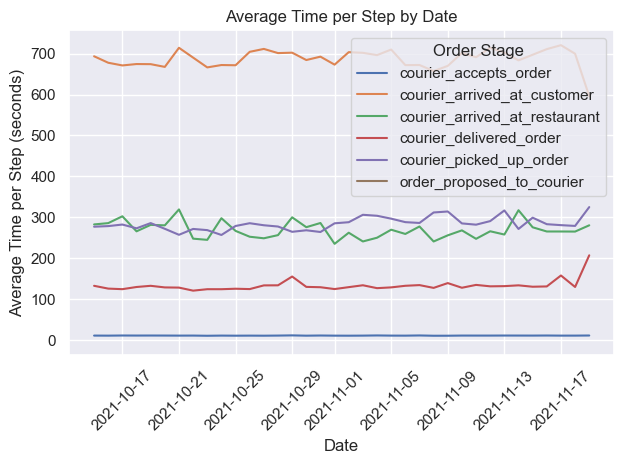

In [265]:
# Grouping the data by date and order stage, calculating the mean time between steps for each date
tmp = stg2.groupby(['order_stage_start_dt', 'order_stage'])['time_between_steps'].mean().unstack()

# Plotting the line graph
plt.figure(figsize=(50, 6))
tmp.plot(kind='line')

# Setting the title and labels for the plot
plt.title('Average Time per Step by Date')
plt.xlabel('Date')
plt.ylabel('Average Time per Step (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Order Stage')

# Displaying the plot
plt.tight_layout()
plt.show()


# Data Insights

## Distribution courier_arrived_at_customer 

/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/2815562244.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()


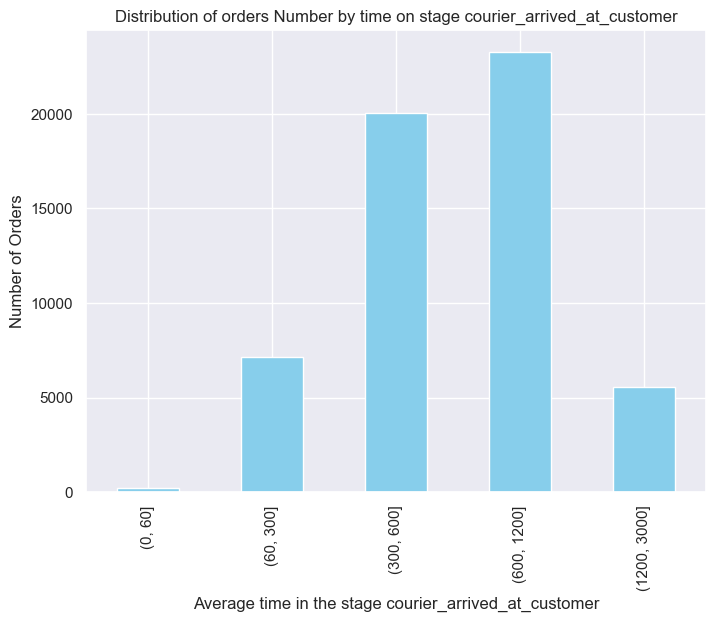

In [234]:
tmp = stg2[stg2['order_stage']=='courier_arrived_at_customer']
tmp = tmp[['order_id', 'time_between_steps']]

bins = [0, 60, 300, 600, 1200, 3000]
tmp['time_between_steps_bins'] = pd.cut(tmp['time_between_steps'], bins)
counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of orders Number by time on stage courier_arrived_at_customer')
plt.xlabel('Average time in the stage courier_arrived_at_customer')
plt.ylabel('Number of Orders')

plt.show()

## Distribution courier_picked_up_order 

/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/4136566174.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()


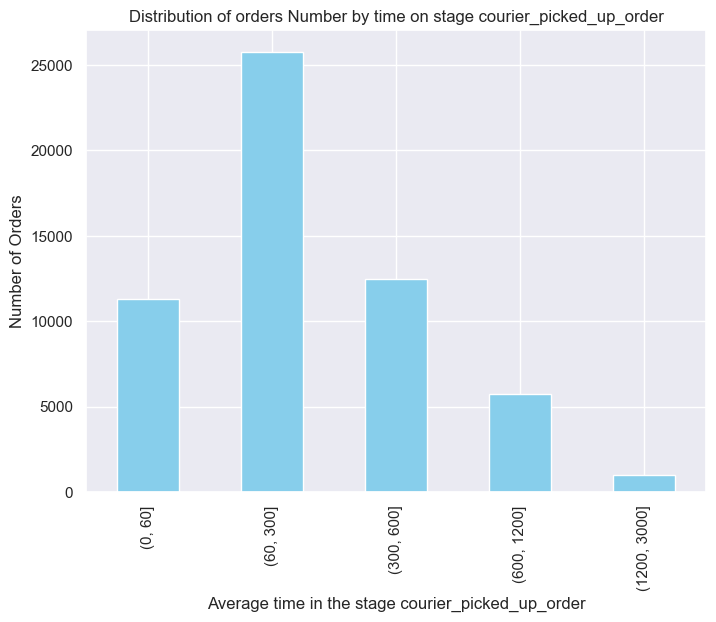

In [235]:
tmp = stg2[stg2['order_stage']=='courier_picked_up_order']
tmp = tmp[['order_id', 'time_between_steps']]

bins = [0, 60, 300, 600, 1200, 3000]
tmp['time_between_steps_bins'] = pd.cut(tmp['time_between_steps'], bins)
counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of orders Number by time on stage courier_picked_up_order')
plt.xlabel('Average time in the stage courier_picked_up_order')
plt.ylabel('Number of Orders')

plt.show()

## Distribution courier_arrived_at_restaurant 

/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/1376316286.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()


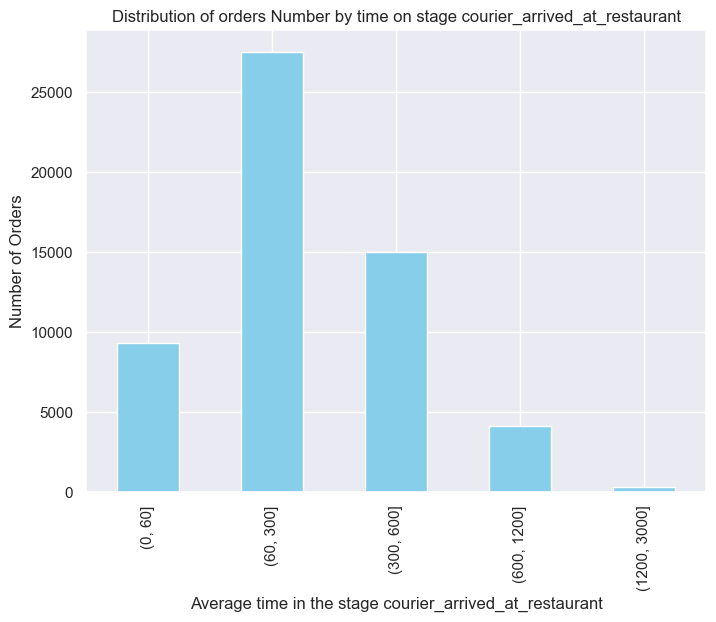

In [236]:
tmp = stg2[stg2['order_stage']=='courier_arrived_at_restaurant']
tmp = tmp[['order_id', 'time_between_steps']]

bins = [0, 60, 300, 600, 1200, 3000]
tmp['time_between_steps_bins'] = pd.cut(tmp['time_between_steps'], bins)
counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of orders Number by time on stage courier_arrived_at_restaurant')
plt.xlabel('Average time in the stage courier_arrived_at_restaurant')
plt.ylabel('Number of Orders')

plt.show()

## Distribution courier_delivered_order 

/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/4129859635.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()


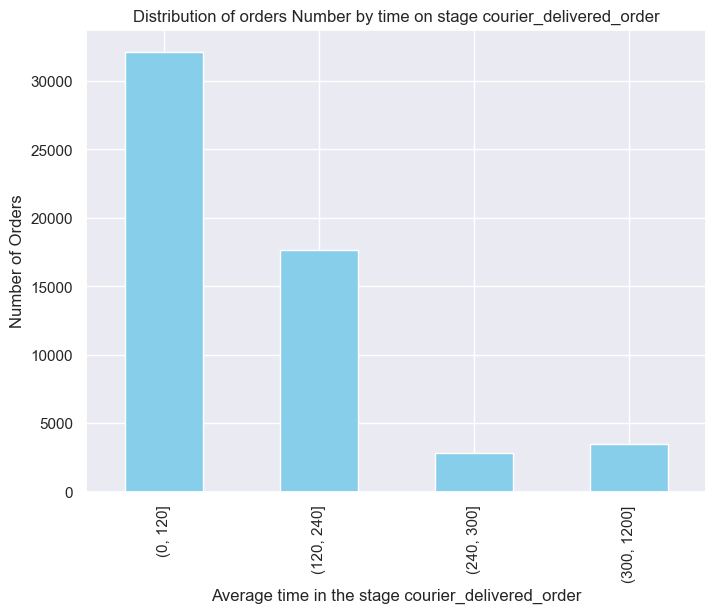

In [237]:
tmp = stg2[stg2['order_stage']=='courier_delivered_order']
tmp = tmp[['order_id', 'time_between_steps']]

bins = [0, 120, 240, 300, 1200]
tmp['time_between_steps_bins'] = pd.cut(tmp['time_between_steps'], bins)
counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of orders Number by time on stage courier_delivered_order')
plt.xlabel('Average time in the stage courier_delivered_order')
plt.ylabel('Number of Orders')

plt.show()

In [148]:
counts

time_between_steps_bins
(0, 60]        19723
(60, 120]      16889
(120, 180]     13228
(180, 240]      6876
(240, 300]      3230
(300, 1200]     3996
Name: order_id, dtype: int64

/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/443708582.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['time_between_steps_bins'] = pd.cut(sums, bins)
/var/folders/m2/x_xj199s1yx5pz8ngc35ly9w0000gn/T/ipykernel_84547/443708582.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()


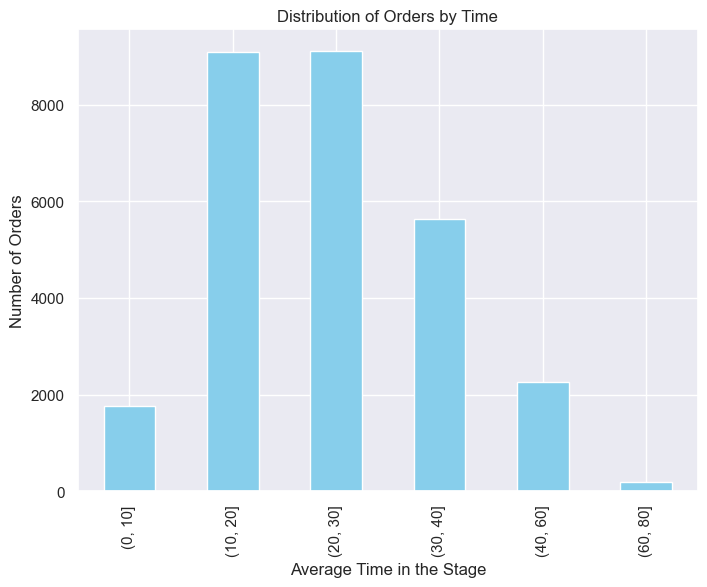

In [238]:
tmp = stg2[['order_id', 'time_between_steps']]

# Grouping by 'order_id' and summing the 'time_between_steps'
sums = tmp.groupby('order_id')['time_between_steps'].sum()/60

# Binning the summed time_between_steps
bins = [0, 10, 20, 30, 40, 60, 80]
tmp['time_between_steps_bins'] = pd.cut(sums, bins)

# Counting the number of orders in each time bin
counts = tmp.groupby('time_between_steps_bins')['order_id'].nunique()

# Plotting the distribution of orders by time
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of Orders by Time')
plt.xlabel('Average Time in the Stage')
plt.ylabel('Number of Orders')

plt.show()

In [178]:
print(counts)
print('------')
print(sums.describe())

time_between_steps_bins
(0, 10]      2227
(10, 20]    24765
(20, 30]    24952
(30, 40]     8984
(40, 60]     2990
(60, 80]      223
Name: order_id, dtype: int64
------
count    64205.000000
mean        23.078941
std         10.753822
min          0.000000
25%         16.533333
50%         21.633333
75%         27.816667
max        949.016667
Name: time_between_steps, dtype: float64


In [171]:
sums = stg.groupby('courier_id')['order_id'].count()
sums.describe()

count    3039.000000
mean      126.665679
std       131.340391
min         2.000000
25%        24.000000
50%        78.000000
75%       186.000000
max       738.000000
Name: order_id, dtype: float64

In [185]:
78*21.5/60/8

3.49375

## Effect estimate

In [279]:
mask1 = stg2['order_stage_start_dt']>= pd.to_datetime('2021-10-15 03:04:02.000').date()
mask2 = stg2['order_stage_start_dt'] < pd.to_datetime('2021-11-15 03:45:27.000').date()
stg2 = stg2[mask1&mask2]
stg2.head(2)

,order_id,courier_id,vehicle_type,order_stage,order_stage_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,updated_expected_delivery_time,order_stage_start_dt,time_between_steps
0,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02,NaN,NaN,2021-10-15 03:27:30,2021-10-15,NaN
1,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12,218.0,NaN,2021-10-15 03:27:10,2021-10-15,10.0


In [280]:
tmp = stg2.groupby(['courier_id','order_stage_start_dt'])['time_between_steps'].sum()
x = round(tmp.median()/60)
print('Average working time per day for 1 courier is', x,'minutes')
tmp = stg2.groupby(['courier_id', 'order_stage_start_dt'])['order_id'].nunique()
y = round(tmp.median())
print('Average orders number per day for 1 courier is', y)
print('Average time for 1 order for courier is', round(x/y,1),'minutes')

Average working time per day for 1 courier is 39 minutes
Average orders number per day for 1 courier is 2
Average time for 1 order for courier is 19.5 minutes


In [285]:
tmp = ord.groupby(['customer_id']).agg({'order_id': 'count'}).reset_index()

tmp = tmp[['customer_id', 'order_id']]

bins = [0, 1, 2, 3, 4, 18]
tmp['order_cnt'] = pd.cut(tmp['order_id'], bins)
counts = tmp.groupby('order_cnt')['customer_id'].count()

print(counts)

order_cnt
(0, 1]     30415
(1, 2]      8327
(2, 3]      2883
(3, 4]      1140
(4, 18]      895
Name: customer_id, dtype: int64


In [278]:
tmp = ord.groupby(['restaurant_id']).agg({'order_id': 'nunique'}).reset_index()

tmp = tmp[['restaurant_id', 'order_id']]

bins = [0, 1, 2, 3, 6, 12, 25, 50, 100, 200, 700]
tmp['order_cnt'] = pd.cut(tmp['order_id'], bins)
counts = tmp.groupby('order_cnt')['restaurant_id'].nunique()

print(counts)

order_cnt
(0, 1]        112
(1, 2]         92
(2, 3]         74
(3, 6]        168
(6, 12]       196
(12, 25]      256
(25, 50]      250
(50, 100]     188
(100, 200]    111
(200, 700]     58
Name: restaurant_id, dtype: int64


# Resolution

## Data discovery

1. More than half of all customers make only 1 order per month.
2. The median number of orders per restaurant is 17, with fewer than 4 orders per month in 278 restaurants and between 4 and 6 orders in 168 restaurants.

## Business case

If we convince at least half of the users who made 1 or 2 orders to make at least 1 more order per month, we will receive an additional 19,371 orders per month or +30%.

## Requirements definition

We can choose the following mechanics: show the user other restaurants in the app.
Among the trivial suggestions, these could be the following options:
- restaurants with high ratings
- restaurants with cuisine similar to the user's order
- restaurants that are geographically close to the user, resulting in minimal delivery time.

## Feature validation

To evaluate the experiment, the following steps need to be taken (briefly):

1. Choose the split-back test, as it involves a three-sided marketplace.
2. Define the target and control metrics.
3. Introduce the feature to the A/B platform.
4. Calculate the Minimum Detectable Effect (MDE) and experiment duration.
5. Configure the setting in the A/B platform.
6. Check for dependencies.
7. Notify potential stakeholders about the experiment.
8. After launch, ensure that the feature functions correctly and users are split correctly.
9. Wait for the experiment to finish and summarize the results.
10. Describe the experiment's outcome, including whether there was any statistically significant difference in the metrics.
11. Present the results to the product manager.